<a href="https://colab.research.google.com/github/NiyazovIlia/Python-Data-Science/blob/Course/Course_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Подключение бибилиотек и данных

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
SUBMIT_PATH = 'sample_submission.csv'

# 2. Загрузка данных в Data Frame

## Описание файлов
1. train.csv - тренировочные данные
2. test.csv - тестовые данные
3. sampleSubmission.csv - образец файла для отправки в правильном формате

## Описание признаков данных
1. Id - идентификационный номер квартиры
2. DistrictId - идентификационный номер района
3. Rooms - количество комнат
4. Square - площадь
5. LifeSquare - жилая площадь
6. KitchenSquare - площадь кухни
7. Floor - этаж
8. HouseFloor - количество этажей в доме
9. HouseYear - год постройки дома
10. Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
11. Social_1, Social_2, Social_3 - социальные показатели местности
12. Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
13. Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
14. Price - цена квартиры

In [2]:
# Импортируем данные train.csv в pandas Dataframe
df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


# 3. EDA

## Основная информация о Data Frame

In [3]:
# Посмотрим основную информацию по все признакам
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [4]:
# Уберем идентификаторы и районы из ввещественных признаков
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)

In [5]:
# Посмотрим основные статистики
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## Вывод по статистикам
Есть пропуски данных у признаков
1. LifeSquare
2. Healthcare_1

Имеются выбросы по значению 0, т.к. в жизни они не могут быть нулевыми, для полей
1. Rooms
2. HouseFloor

Дополнительно есть подозрения на:
1. Square площадь помещения равная 1,13 не может встречаться в реальных условиях
2. LifeSquare жилая площадь помещения равная 0,37 не может встречаться в реальных условиях

## Исследование вещественных признаков

In [6]:
df_num_features = df_train.select_dtypes(include=['float64', 'int64'])

for i in df_num_features:
  print('\nКоличество уникальных значений признака ' + i + '\n')
  print(df_train[i].value_counts())


Количество уникальных значений признака Rooms

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Количество уникальных значений признака Square

26.553188     1
46.363496     1
100.751999    1
70.726600     1
40.523022     1
             ..
76.481158     1
86.915187     1
82.482521     1
43.112986     1
97.664912     1
Name: Square, Length: 10000, dtype: int64

Количество уникальных значений признака LifeSquare

28.003539    1
19.224066    1
21.613298    1
25.688943    1
44.662105    1
            ..
37.980219    1
17.130385    1
33.273700    1
28.313300    1
28.421652    1
Name: LifeSquare, Length: 7887, dtype: int64

Количество уникальных значений признака KitchenSquare

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         2

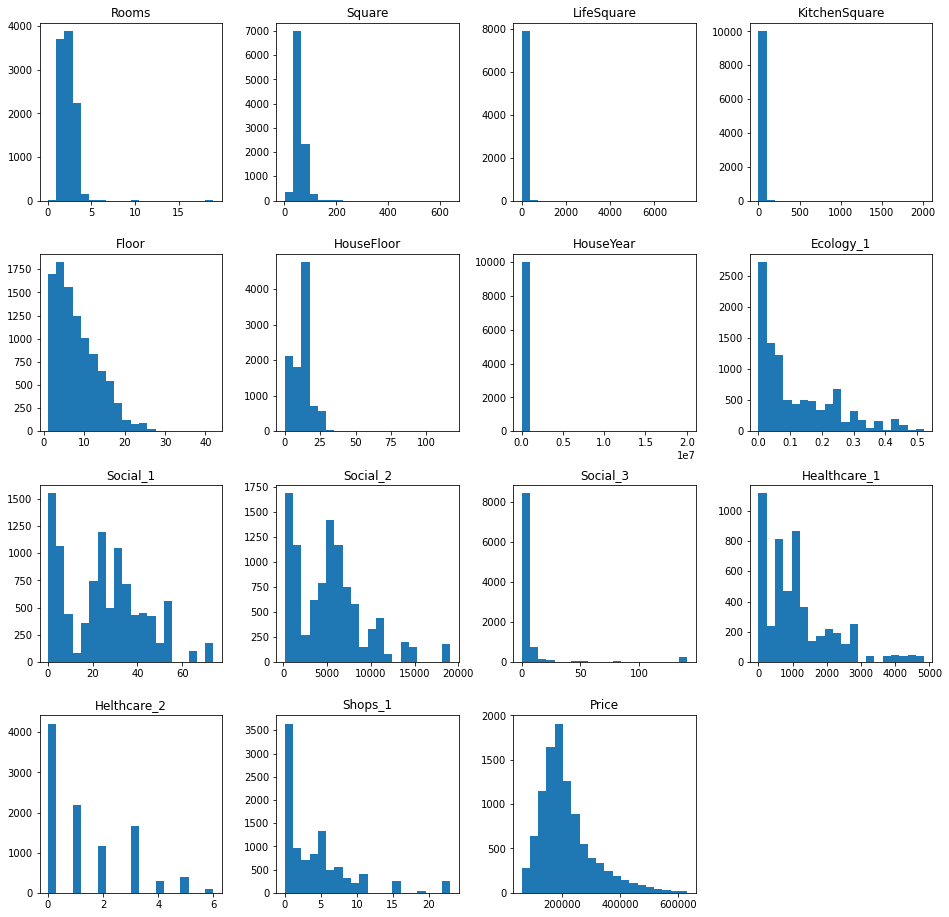

In [7]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)
plt.show()

## Исследование номинативных признаков

In [8]:
df_obj_features = df_train.select_dtypes(include=['object'])

for i in df_obj_features:
  print('\nКоличество уникальных значений признака ' + i + '\n')
  print(df_train[i].value_counts())


Количество уникальных значений признака Id

13703    1
8628     1
12377    1
15487    1
16653    1
        ..
4430     1
2959     1
14138    1
9536     1
5575     1
Name: Id, Length: 10000, dtype: int64

Количество уникальных значений признака DistrictId

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
207      1
209      1
174      1
196      1
Name: DistrictId, Length: 205, dtype: int64

Количество уникальных значений признака Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64

Количество уникальных значений признака Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64

Количество уникальных значений признака Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64


## Исследование целевой переменной

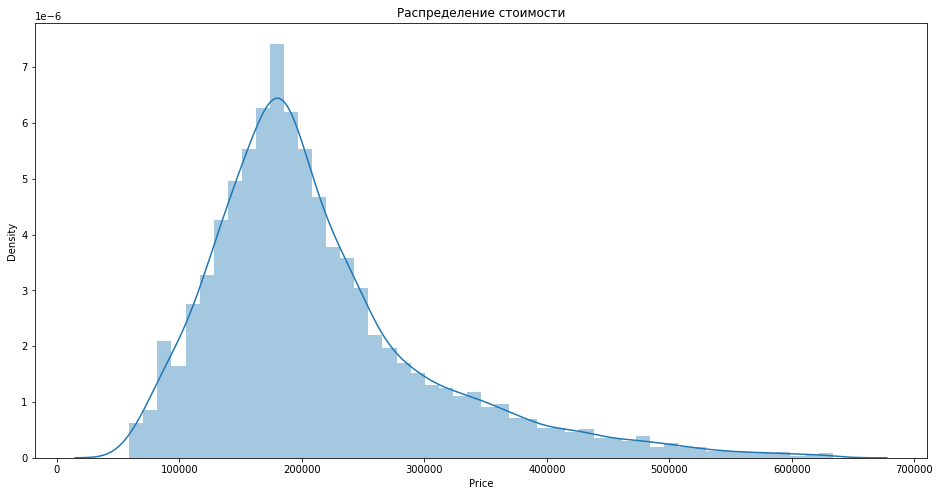

In [9]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train['Price'])

plt.title('Распределение стоимости')
plt.show()

## Матрица корреляций

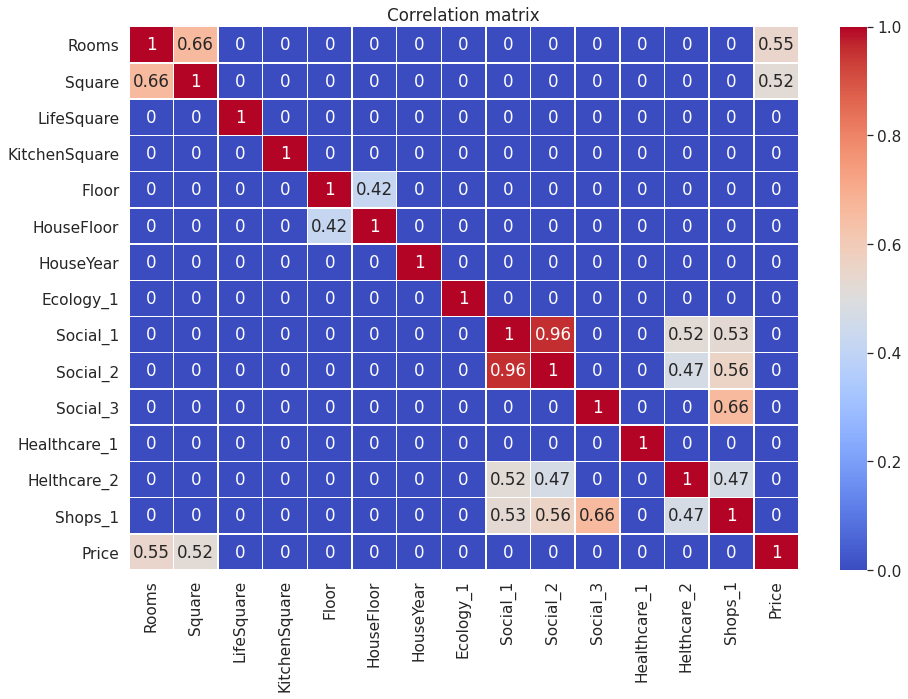

In [10]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr() # вызов корреляции
corr_matrix = np.round(corr_matrix, 2) # сколько знаки после запятой
corr_matrix[np.abs(corr_matrix) < 0.3] = 0 # все что меньше 0,3 по модулю равно 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm') # строим матрицу корреляций

plt.title('Correlation matrix')
plt.show()

# 4. Обработка выбросов и пропусков

## Rooms

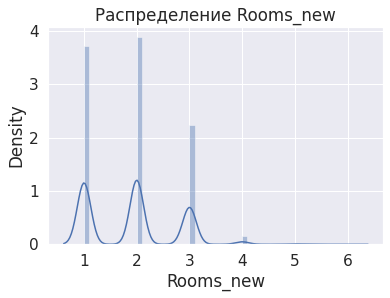

count    10000.000000
mean         1.887700
std          0.812622
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: Rooms_new, dtype: float64

In [11]:
df_train['Rooms_new'] = df_train['Rooms']
df_train.loc[df_train['Rooms_new'] > 6, 'Rooms_new'] = df_train['Rooms_new'].std()
df_train.loc[df_train['Rooms_new'] <= 1, 'Rooms_new'] = 1


sns.distplot(df_train['Rooms_new'])
plt.title('Распределение Rooms_new')
plt.show()

df_train['Rooms_new'].describe()

## Square, LifeSquare, KitchenSquare

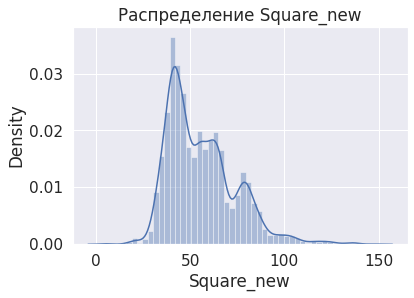

count    10000.000000
mean        55.802305
std         18.249664
min          4.380726
25%         41.706521
50%         52.361403
75%         65.820977
max        148.671938
Name: Square_new, dtype: float64

In [12]:
# Уберем объекты площадью меньше 4 и больше 150. Урежем хвосты и околонулевые значения
df_train['Square_new'] = df_train['Square']
df_train.loc[df_train['Square_new'] > 150, 'Square_new'] = df_train['Square_new'].std()
df_train.loc[df_train['Square_new'] < 4, 'Square_new'] = df_train['Square_new'].std()

sns.distplot(df_train['Square_new'])
plt.title('Распределение Square_new')
plt.show()

df_train['Square_new'].describe()

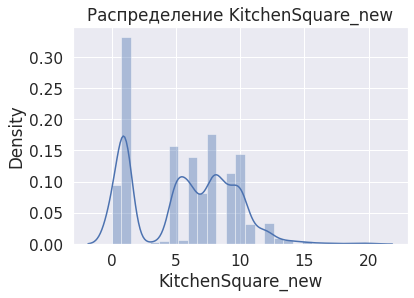

count    10000.000000
mean         5.671884
std          3.874710
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max         20.000000
Name: KitchenSquare_new, dtype: float64

In [13]:
# Почистим значения KitchenSquare которые больше Square
# Определим коэффициент отношения площади кухни к общей площади
df_train['KitchenSquare_new'] = df_train['KitchenSquare']
k_std_sq = df_train['KitchenSquare_new'].std() / df_train['Square_new'].std()

# исправим площадь кухни
df_train.loc[(df_train['KitchenSquare_new'] > df_train['Square_new']), 'KitchenSquare_new'] = k_std_sq * df_train['Square_new']
df_train.loc[df_train['KitchenSquare_new'] > 20, 'KitchenSquare_new'] = df_train['KitchenSquare_new'].std()

sns.distplot(df_train['KitchenSquare_new'])
plt.title('Распределение KitchenSquare_new')
plt.show()

df_train['KitchenSquare_new'].describe()

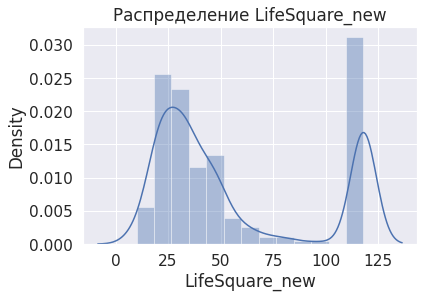

count    10000.000000
mean        56.102780
std         38.776467
min         10.000000
25%         25.540634
50%         38.612985
75%        117.916965
max        117.916965
Name: LifeSquare_new, dtype: float64

In [14]:
#Исправим пропуски LifeSquare как произведение общей площади на коэффциент жилой площади от общей
df_train['LifeSquare_new'] = df_train['LifeSquare']
lf_std_s = df_train['LifeSquare_new'].std() / df_train['Square_new'].std()
df_train.loc[(df_train['LifeSquare_new'] > df_train['Square_new']) | 
             (df_train['LifeSquare_new'].isna()), 'LifeSquare_new'] = lf_std_s * df_train['Square_new']
df_train.loc[(df_train['LifeSquare_new'] > 100, 'LifeSquare_new')] = df_train['LifeSquare_new'].std()
df_train.loc[(df_train['LifeSquare_new'] < 10, 'LifeSquare_new')] = 10

sns.distplot(df_train['LifeSquare_new'])
plt.title('Распределение LifeSquare_new')
plt.show()

df_train['LifeSquare_new'].describe()

## HouseYer

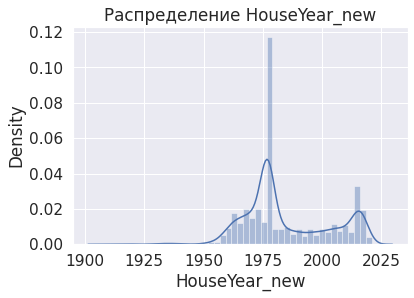

count    10000.000000
mean      1984.872600
std         18.416734
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2021.000000
Name: HouseYear_new, dtype: float64

In [15]:
now = datetime.datetime.now()
df_train['HouseYear_new'] = df_train['HouseYear']
df_train.loc[(df_train['HouseYear_new'] > now.year), 'HouseYear_new'] = now.year

sns.distplot(df_train['HouseYear_new'])
plt.title('Распределение HouseYear_new')
plt.show()

df_train['HouseYear_new'].describe()

## Florr, HouseFloor

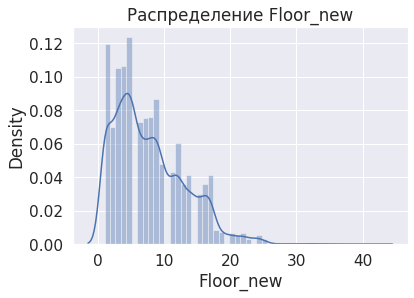

count    10000.000000
mean         7.727300
std          5.267344
min          1.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         42.000000
Name: Floor_new, dtype: float64

In [16]:
# обработаем нулевые этажи
df_train['Floor_new'] = df_train['Floor']
df_train['HouseFloor_new'] = df_train['HouseFloor']
df_train.loc[(df_train['Floor_new'] == 0), 'Floor_new'] = 1
df_train.loc[(df_train['HouseFloor_new'] == 0), 'HouseFloor_new'] = 1

# обработаем ситуацию когда этаж больше этажности
df_train.loc[(df_train['Floor_new'] > df_train['HouseFloor_new']), 'Floor_new'] = df_train['HouseFloor_new']

sns.distplot(df_train['Floor_new'])
plt.title('Распределение Floor_new')
plt.show()

df_train['Floor_new'].describe()

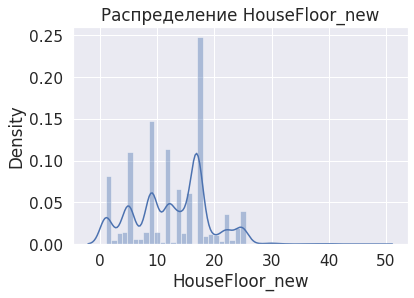

count    10000.000000
mean        12.606818
std          6.533757
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         48.000000
Name: HouseFloor_new, dtype: float64

In [17]:
# Уберем хвост из наблюдений, где этажность больше 50. Их всего 3
df_train.loc[(df_train['HouseFloor_new'] > 50), 'HouseFloor_new'] = df_train['HouseFloor_new'].std()

sns.distplot(df_train['HouseFloor_new'])
plt.title('Распределение HouseFloor_new')
plt.show()

df_train['HouseFloor_new'].describe()

## Social_3

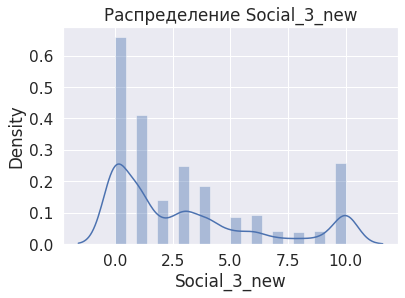

count    10000.000000
mean         3.050800
std          3.361153
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max         10.000000
Name: Social_3_new, dtype: float64

In [18]:
# Из ранее опредеденных параметров выровняем количество человек в квартире
df_train['Social_3_new'] = df_train['Social_3']
df_train.loc[(df_train['Social_3_new'] > 10), 'Social_3_new'] = df_train['Social_3_new'].std()
df_train.loc[(df_train['Social_3_new'] > 10), 'Social_3_new'] = 10

sns.distplot(df_train['Social_3_new'])
plt.title('Распределение Social_3_new')
plt.show()

df_train['Social_3_new'].describe()

## Healthcare_1

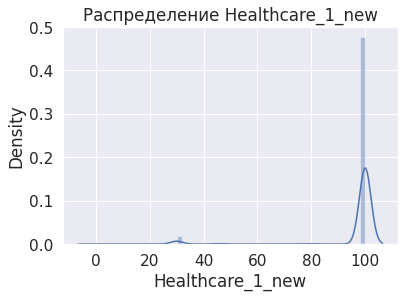

count    10000.000000
mean        97.084800
std         13.642669
min          0.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: Healthcare_1_new, dtype: float64

In [19]:
df_train['Healthcare_1_new'] = df_train['Healthcare_1']
df_train.loc[df_train['Healthcare_1_new'].isna(), 'Healthcare_1_new'] = df_train['Healthcare_1_new'].std()
df_train.loc[df_train['Healthcare_1_new'] > 100, 'Healthcare_1_new'] = 100

sns.distplot(df_train['Healthcare_1_new'])
plt.title('Распределение Healthcare_1_new')
plt.show()

df_train['Healthcare_1_new'].describe()

## Результаты обработки

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 10000 non-null  object 
 1   DistrictId         10000 non-null  object 
 2   Rooms              10000 non-null  float64
 3   Square             10000 non-null  float64
 4   LifeSquare         7887 non-null   float64
 5   KitchenSquare      10000 non-null  float64
 6   Floor              10000 non-null  int64  
 7   HouseFloor         10000 non-null  float64
 8   HouseYear          10000 non-null  int64  
 9   Ecology_1          10000 non-null  float64
 10  Ecology_2          10000 non-null  object 
 11  Ecology_3          10000 non-null  object 
 12  Social_1           10000 non-null  int64  
 13  Social_2           10000 non-null  int64  
 14  Social_3           10000 non-null  int64  
 15  Healthcare_1       5202 non-null   float64
 16  Helthcare_2        1000

## Номинативные признаки

In [21]:
litera = {'A': 0, 'B': 1}

df_train['Ecology_2_new'] = df_train['Ecology_2']
df_train['Ecology_3_new'] = df_train['Ecology_3']
df_train['Shops_2_new'] = df_train['Shops_2']

df_train['Ecology_2_new'] = df_train['Ecology_2_new'].replace(litera)
df_train['Ecology_3_new'] = df_train['Ecology_3_new'].replace(litera)
df_train['Shops_2_new'] = df_train['Shops_2_new'].replace(litera)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_new,Square_new,KitchenSquare_new,LifeSquare_new,HouseYear_new,Floor_new,HouseFloor_new,Social_3_new,Healthcare_1_new,Ecology_2_new,Ecology_3_new,Shops_2_new
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,3.0,115.027311,10.0,117.916965,2014,4.0,10.0,0.0,100.0,1,1,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,1.0,39.832524,8.0,23.169223,1966,7.0,8.0,1.0,100.0,1,1,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,3.0,78.342215,10.0,47.671972,1988,2.0,17.0,0.0,100.0,1,1,1
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,1.0,40.409907,1.0,117.916965,1977,10.0,22.0,0.0,100.0,1,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,2.0,64.285067,9.0,38.562517,1972,16.0,16.0,2.0,100.0,1,1,1


In [22]:
df_train_new = df_train[{'Id','DistrictId', 'Rooms_new', 'Square_new','KitchenSquare_new', 'LifeSquare_new', 'Floor_new', 'HouseFloor_new','HouseYear_new', 'Ecology_1','Ecology_2_new','Ecology_3_new','Social_1','Social_2', 'Social_3_new','Healthcare_1_new','Helthcare_2','Shops_1','Shops_2_new','Price'}]
df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HouseYear_new      10000 non-null  int64  
 1   Social_2           10000 non-null  int64  
 2   Floor_new          10000 non-null  float64
 3   Social_3_new       10000 non-null  float64
 4   DistrictId         10000 non-null  object 
 5   Rooms_new          10000 non-null  float64
 6   Shops_1            10000 non-null  int64  
 7   Helthcare_2        10000 non-null  int64  
 8   HouseFloor_new     10000 non-null  float64
 9   Id                 10000 non-null  object 
 10  Price              10000 non-null  float64
 11  KitchenSquare_new  10000 non-null  float64
 12  Ecology_1          10000 non-null  float64
 13  Square_new         10000 non-null  float64
 14  Ecology_2_new      10000 non-null  int64  
 15  Ecology_3_new      10000 non-null  int64  
 16  LifeSquare_new     1000

# 5. Классы подготовки данных

In [23]:
class dataPrepare():
    def transform(self, X):

        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)

        X['Rooms_new'] = X['Rooms']
        X.loc[X['Rooms_new'] > 6, 'Rooms_new'] = X['Rooms_new'].std()
        X.loc[X['Rooms_new'] <= 1, 'Rooms_new'] = 1

        X['Square_new'] = X['Square']
        X.loc[X['Square_new'] > 150, 'Square_new'] = X['Square_new'].std()
        X.loc[X['Square_new'] < 4, 'Square_new'] = X['Square_new'].std()

        X['KitchenSquare_new'] = X['KitchenSquare']
        k_std_sq = X['KitchenSquare_new'].std() / X['Square_new'].std()
        X.loc[(X['KitchenSquare_new'] > X['Square_new']), 'KitchenSquare_new'] = k_std_sq * X['Square_new']
        X.loc[X['KitchenSquare_new'] > 20, 'KitchenSquare_new'] = X['KitchenSquare_new'].std()


        X['LifeSquare_new'] = X['LifeSquare']
        lf_std_s = X['LifeSquare_new'].std() / X['Square_new'].std()
        X.loc[(X['LifeSquare_new'] > X['Square_new']) | 
                (X['LifeSquare_new'].isna()), 'LifeSquare_new'] = lf_std_s * X['Square_new']
        X.loc[(X['LifeSquare_new'] > 100, 'LifeSquare_new')] = X['LifeSquare_new'].std()
        X.loc[(X['LifeSquare_new'] < 10, 'LifeSquare_new')] = 10

        now = datetime.datetime.now()
        X['HouseYear_new'] = X['HouseYear']
        X.loc[(X['HouseYear_new'] > now.year), 'HouseYear_new'] = now.year

        X['Floor_new'] = X['Floor']
        X['HouseFloor_new'] = X['HouseFloor']
        X.loc[(X['Floor_new'] == 0), 'Floor_new'] = 1
        X.loc[(X['HouseFloor_new'] == 0), 'HouseFloor_new'] = 1
        X.loc[(X['Floor_new'] > X['HouseFloor_new']), 'Floor_new'] = X['HouseFloor_new']

        X.loc[(X['HouseFloor_new'] > 50), 'HouseFloor_new'] = X['HouseFloor_new'].std()

        X['Social_3_new'] = X['Social_3']
        X.loc[(X['Social_3_new'] > 10), 'Social_3_new'] = X['Social_3_new'].std()
        X.loc[(X['Social_3_new'] > 10), 'Social_3_new'] = 10

        X['Healthcare_1_new'] = X['Healthcare_1']
        X.loc[X['Healthcare_1_new'].isna(), 'Healthcare_1_new'] = X['Healthcare_1_new'].std()
        X.loc[X['Healthcare_1_new'] > 100, 'Healthcare_1_new'] = 100

        return X

class dataDummies():
    def transform(self, X):

        self.binary_to_numbers = {'A': 0, 'B': 1}

        X['Ecology_2_new'] = X['Ecology_2']
        X['Ecology_3_new'] = X['Ecology_3']
        X['Shops_2_new'] = X['Shops_2']

        X['Ecology_2_new'] = X['Ecology_2_new'].map(self.binary_to_numbers)
        X['Ecology_3_new'] = X['Ecology_3_new'].map(self.binary_to_numbers)
        X['Shops_2_new'] = X['Shops_2_new'].map(self.binary_to_numbers)
        return X

# 6. Дополнительные функции

In [24]:
def r2_metrics(y_tr, y_ts, y_tr_prd, y_ts_prd):
    # Посчитаем коэффициент детерминации R2
    print("R2 TRAIN:\t" + str(r2_score(y_tr, y_tr_prd)))
    print("R2 TEST:\t" + str(r2_score(y_ts, y_ts_prd)))

# 7. Разбиение на train и test

In [25]:
x_train = pd.read_csv(TRAIN_PATH)
x_test = pd.read_csv(TEST_PATH)

transform_1 = dataPrepare()
transform_2 = dataDummies()

x_train = transform_1.transform(x_train)
x_train = transform_2.transform(x_train)


x_test = transform_1.transform(x_test)
x_test = transform_2.transform(x_test)


X = x_train[{'Id','DistrictId', 'Rooms_new', 'Square_new','KitchenSquare_new', 'LifeSquare_new', 'Floor_new', 'HouseFloor_new','HouseYear_new', 'Ecology_1','Ecology_2_new','Ecology_3_new','Social_1','Social_2', 'Social_3_new','Healthcare_1_new','Helthcare_2','Shops_1','Shops_2_new'}]
y = pd.DataFrame(x_train['Price'])

x_test = x_test[{'Id','DistrictId', 'Rooms_new', 'Square_new','KitchenSquare_new', 'LifeSquare_new', 'Floor_new', 'HouseFloor_new','HouseYear_new', 'Ecology_1','Ecology_2_new','Ecology_3_new','Social_1','Social_2', 'Social_3_new','Healthcare_1_new','Helthcare_2','Shops_1','Shops_2_new'}]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

print(X_train.shape, X_test.shape, x_test.shape)
print(X_train.isna().sum().sum(), 
      X_test.isna().sum().sum(),
      x_test.isna().sum().sum())

(6700, 19) (3300, 19) (5000, 19)
0 0 0


# 8. Построение модели

In [26]:
scaler = StandardScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)


gbr = GradientBoostingRegressor(criterion='mse',
                                        max_depth=4,
                                        random_state=42,  
                                        n_estimators=350)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=350,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2 TRAIN:	0.8952024646904325
R2 TEST:	0.7563853204931139


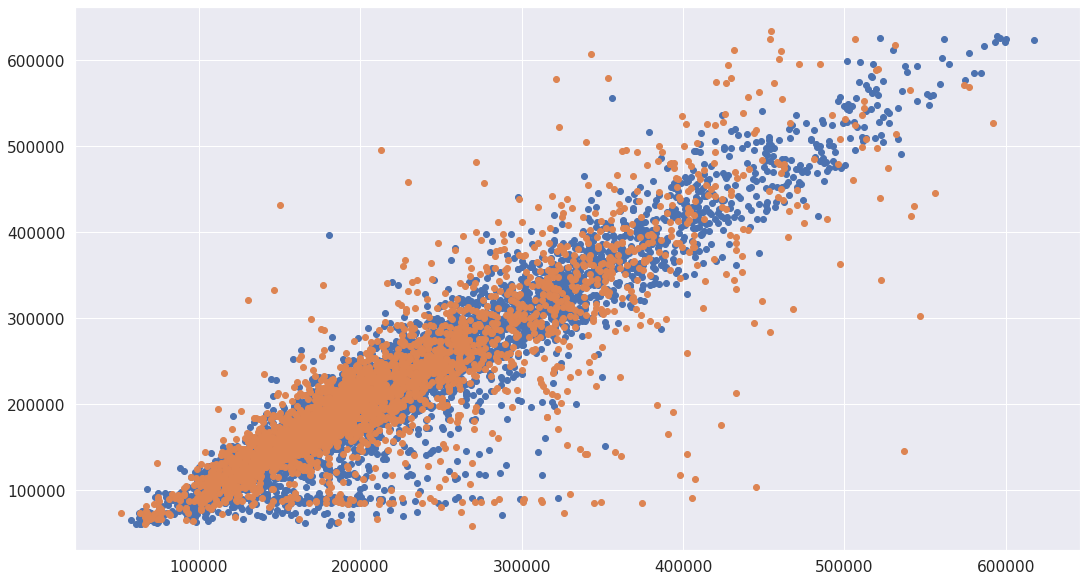

In [27]:
y_train_preds_gbr = gbr.predict(X_train)
y_test_preds_gbr = gbr.predict(X_test)

r2_metrics(y_train, y_test, y_train_preds_gbr, y_test_preds_gbr)


plt.figure(figsize=(18,10))
a = pd.DataFrame({'Price':y_train_preds_gbr})
plt.scatter(a, y_train)

b = pd.DataFrame({'Price':y_test_preds_gbr})
plt.scatter(b, y_test)

# 9. Прогноз на тестовом dataset

In [28]:
x_train = pd.read_csv(TRAIN_PATH)
x_test = pd.read_csv(TEST_PATH)

transform_1 = dataPrepare()
transform_2 = dataDummies()

x_train = transform_1.transform(x_train)
x_train = transform_2.transform(x_train)


x_test = transform_1.transform(x_test)
x_test = transform_2.transform(x_test)


X = x_train[{'Id','DistrictId', 'Rooms_new', 'Square_new','KitchenSquare_new', 'LifeSquare_new', 'Floor_new', 'HouseFloor_new','HouseYear_new', 'Ecology_1','Ecology_2_new','Ecology_3_new','Social_1','Social_2', 'Social_3_new','Healthcare_1_new','Helthcare_2','Shops_1','Shops_2_new'}]
y = pd.DataFrame(x_train['Price'])

X_test = x_test[{'Id','DistrictId', 'Rooms_new', 'Square_new','KitchenSquare_new', 'LifeSquare_new', 'Floor_new', 'HouseFloor_new','HouseYear_new', 'Ecology_1','Ecology_2_new','Ecology_3_new','Social_1','Social_2', 'Social_3_new','Healthcare_1_new','Helthcare_2','Shops_1','Shops_2_new'}]

print(X.shape, X_test.shape)
print(X.isna().sum().sum(), 
      X_test.isna().sum().sum())

(10000, 19) (5000, 19)
0 0


In [29]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=4,
                                        random_state=42,  
                                        n_estimators=350)

final_model.fit(X, y)

y_test_preds_gbr = final_model.predict(X_test)

In [30]:
submit = pd.read_csv(SUBMIT_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [31]:
submit['Price'] = y_test_preds_gbr
submit.head()

,Id,Price
0,4567,163422.403884
1,5925,117698.397724
2,960,150206.917172
3,3848,116002.860635
4,746,196380.069844


In [32]:
submit.to_csv('gbr_submit.csv', index=False)